#### Preparing data
Run the next cells to download and prepare the datasets and util functions.

In [1]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [2]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann_leaf_classification/master/init.py
    from init import download_utils, unzip_leaf_dataset, dataset_dir
    download_utils(force_download=False)

In [3]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf" -O local/datasets/leaf.zip && rm -rf /tmp/cookies.txt

In [4]:
if download_data:
    unzip_leaf_dataset()

#### Notebook start

In [12]:
import os
import random
import numpy as np
import pandas as pd
import progressbar
import matplotlib.pyplot as plt

import local.lib as lib
from init import dataset_dir

from skimage import io
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from importlib import reload
reload(lib)

import warnings
warnings.filterwarnings('ignore')

# Baseline Model
We want to have a model of classical Machine learning. This model is good to make comparison with the deep learning models. 


## 1. Get datasets

In [14]:
X_train, _,_, y_train, X_test, _,_, y_test, species, num_classes, _, _ = lib.get_splitted_data(data_dir=dataset_dir, check_id_sets=True, verbose=1)

The intersection between train and test set is 0
There are 99 classes for the classification task.


In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((693, 194), (693,), (297, 194), (297,))

## 2. ML model

In [16]:
model = LinearDiscriminantAnalysis()

In [17]:
model.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [18]:
tr_pred = model.predict(X_train)
train_accuracy = (tr_pred == y_train).mean()
train_accuracy

1.0

In [19]:
ts_pred = model.predict(X_test)
test_accuracy = (ts_pred == y_test).mean()
test_accuracy

0.9663299663299664

## 3. Model stability

In [20]:
N = 10

In [22]:
train_results = []
test_results = []

for i in progressbar.ProgressBar()(range(N)):
    
    # get data
    X_train, _,_, y_train, X_test, _,_, y_test, species, num_classes, _, _ = lib.get_splitted_data(data_dir=dataset_dir)
    
    # model
    model = LinearDiscriminantAnalysis()
    model.fit(X_train, y_train)
    
    # train results
    tr_pred = model.predict(X_train)
    train_accuracy = (tr_pred == y_train).mean()
    
    # test results
    ts_pred = model.predict(X_test)
    test_accuracy = (ts_pred == y_test).mean()
    
    train_results.append(train_accuracy)
    test_results.append(test_accuracy)
    

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [23]:
train_results

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [24]:
print("Test mean accuracy for {} experiments: {:.3f}".format(N, np.mean(test_results)))
print("Test std accuracy for {} experiments: {:.3f}".format(N, np.std(test_results)))

Test mean accuracy for 10 experiments: 0.980
Test std accuracy for 10 experiments: 0.006


Text(0, 0.5, 'y_pred')

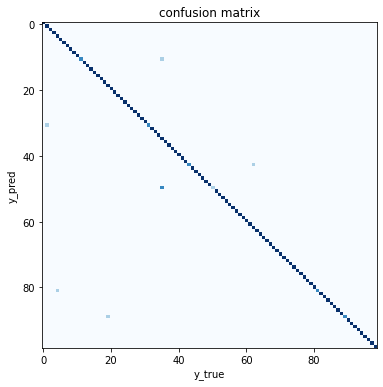

In [25]:
cm = confusion_matrix(y_pred=ts_pred, y_true=y_test)

plt.figure(figsize=(6,6))
plt.imshow(cm, aspect="auto", cmap="Blues")
plt.title("confusion matrix")
plt.xlabel("y_true")
plt.ylabel("y_pred")

In [27]:
N = 10
splits = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [29]:
train_results = []
test_results = []

for split in progressbar.ProgressBar()(splits):
    
    rtrain = []
    rtest = []

    for i in range(N):

        # get data
        X_train, _,_, y_train, X_test, _,_, y_test, species, num_classes, _, _ = lib.get_splitted_data(data_dir=dataset_dir, split=split)

        # model
        model = LinearDiscriminantAnalysis()
        model.fit(X_train, y_train)

        # train results
        tr_pred = model.predict(X_train)
        train_accuracy = (tr_pred == y_train).mean()

        # test results
        ts_pred = model.predict(X_test)
        test_accuracy = (ts_pred == y_test).mean()

        rtrain.append(train_accuracy)
        rtest.append(test_accuracy)
    
    train_results.append(rtrain)
    test_results.append(rtest)
    

100% (7 of 7) |##########################| Elapsed Time: 0:00:11 Time:  0:00:11


In [30]:
tr_m = [np.mean(i) for i in train_results]
tr_s = [np.std(i) for i in train_results]

In [31]:
ts_m = np.array([np.mean(i) for i in test_results])
ts_s = np.array([np.std(i) for i in test_results])

Text(0, 0.5, 'accuracy')

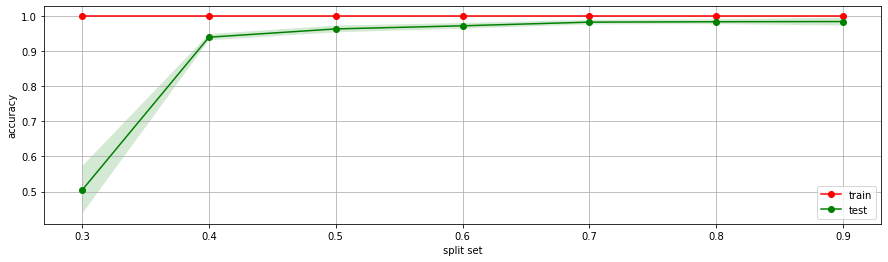

In [32]:
plt.figure(figsize=(15,4))

plt.plot(tr_m, label="train", color="red", marker="o")
plt.plot(ts_m, label="test", color="green", marker="o")
plt.fill_between(range(len(splits)), ts_m+ts_s, ts_m-ts_s, facecolor='green', interpolate=True, alpha=0.17)

plt.grid()
plt.legend()
_=plt.xticks(range(len(splits)), splits)
plt.xlabel("split set")
plt.ylabel("accuracy")